# Week 4 Phase 4A: Transfer Learning with ResNet50

**Learning Objective**: Understand when and why transfer learning can fail for Earth observation tasks

**Result**: This phase demonstrates a **failed experiment** (22.67% accuracy vs Week 3's 86.67% baseline). The failure provides valuable insights about:
- Domain mismatch between ImageNet and satellite imagery
- Aggressive layer freezing (85% frozen)
- Small patch size and upsampling artifacts
- When to train from scratch instead of using transfer learning

---

## Contents
1. Setup and Load Data
2. Load Pretrained ResNet50
3. Modify Architecture (Upsampling + Band Reduction)
4. Train Transfer Learning Model
5. Evaluate and Compare to Week 3
6. Root Cause Analysis
7. Lessons Learned

## How to use this notebook (and what you will learn)

This notebook walks you through a complete transfer learning attempt with ResNet‑50 on multispectral Sentinel‑2 patches. As you follow along, focus on:

- What we change to adapt an ImageNet model to satellite data (8×8×6 patches → 32×32×3 pseudo‑RGB → ResNet‑50).
- How freezing strategy and learning rate influence whether transfer learning adapts or collapses.
- How to read training curves and a confusion matrix to diagnose failure modes (e.g., single‑class predictions).

Week 4 learning objectives you will practice here:
- Implement and fine‑tune a pretrained CNN (ResNet‑50) for Earth observation.
- Modify backbones for multispectral inputs and small patches; reason about design trade‑offs.
- Evaluate results with metrics and ablations; interpret when transfer helps vs hurts.
- Document a reproducible pipeline and reflect on negative results as scientifically valuable.


### Data understanding and sanity checks

Before training, verify shapes, ranges, and class balance. For this notebook:

- Expected shapes: X_train (300, 8, 8, 6), X_val (75, 8, 8, 6)
- Values are scaled to [0, 1] by dividing by 10,000.
- Five classes: Agriculture, Forest, Parcels, Urban, Water.

Why this matters:
- Shape mismatches break transfer learning pipelines.
- Wrong scaling can stall convergence.
- Imbalanced splits (e.g., validation with one class) invalidate results. Always use stratified splits and confirm distributions.


---
## 1. Setup and Load Week 3 Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")

TensorFlow: 2.20.0
NumPy: 2.3.3


In [2]:
# Setup paths
WEEK4_DIR = Path.cwd()
DATA_DIR = WEEK4_DIR.parent.parent / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
PHASE4A_DIR = WEEK4_DIR / 'phase4a_outputs'
PHASE4A_DIR.mkdir(exist_ok=True)

# Load Week 3 dataset (6-band Sentinel-2)
X_train = np.load(PROCESSED_DIR / 'X_train.npy')
y_train = np.load(PROCESSED_DIR / 'y_train.npy')
X_val = np.load(PROCESSED_DIR / 'X_val.npy')
y_val = np.load(PROCESSED_DIR / 'y_val.npy')

# Normalize to [0, 1]
X_train_norm = X_train.astype(np.float32) / 10000.0
X_val_norm = X_val.astype(np.float32) / 10000.0

print(f"Training: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation: {X_val.shape}, Labels: {y_val.shape}")
print(f"Classes: {np.unique(y_train)} (0=Agriculture, 1=Forest, 2=Parcels, 3=Urban, 4=Water)")

Training: (300, 8, 8, 6), Labels: (300,)
Validation: (75, 8, 8, 6), Labels: (75,)
Classes: [0 1 2 3 4] (0=Agriculture, 1=Forest, 2=Parcels, 3=Urban, 4=Water)


---
## 2. Load Pretrained ResNet50

**Challenge**: ResNet50 expects:
- **Input size**: ≥32×32 pixels (we have 8×8)
- **Channels**: 3 bands RGB (we have 6 bands multispectral)
- **Domain**: Natural images from ImageNet (we have satellite imagery)

**Transfer learning strategy**:
- Freeze early layers (150/175 = 85.7%) to preserve ImageNet features
- Train only last 25 layers to adapt to our task
- **⚠️ Warning**: This aggressive freezing will prove to be too much

In [3]:
# Load pretrained ResNet50 (without top classification layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3),  # Minimum size for ResNet50
    pooling=None
)

print(f"ResNet50 Architecture:")
print(f"  Total layers: {len(base_model.layers)}")
print(f"  Total parameters: {base_model.count_params():,}")
print(f"  Pretrained on: ImageNet (1.2M images, 1000 classes)")
print(f"\n⚠️  Note: This model was trained on natural RGB images, not multispectral satellite data")

ResNet50 Architecture:
  Total layers: 175
  Total parameters: 23,587,712
  Pretrained on: ImageNet (1.2M images, 1000 classes)

⚠️  Note: This model was trained on natural RGB images, not multispectral satellite data


---
## 3. Modify Architecture for Multispectral Input

**Problem 1**: Our patches are 8×8 pixels, ResNet50 needs ≥32×32
- **Solution**: UpSampling2D (8×8 → 32×32, 4× bilinear interpolation)
- **⚠️ Issue**: Upsampling creates artifacts, no new information

**Problem 2**: Our patches have 6 bands, ResNet50 expects 3
- **Solution**: 1×1 Conv2D to reduce 6 bands → 3 pseudo-RGB
- **⚠️ Issue**: Information loss, 6D → 3D compression

**Architecture**:
```
Input (8×8×6) → UpSample → (32×32×6) → Conv1×1 → (32×32×3) → ResNet50 → Output (5 classes)
```

In [4]:
# Build transfer learning model
inputs = layers.Input(shape=(8, 8, 6), name='sentinel2_input')

# Upsample 8×8 → 32×32 (4× bilinear interpolation)
x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upsample_to_32x32')(inputs)

# Reduce 6 bands → 3 pseudo-RGB
x = layers.Conv2D(3, kernel_size=1, padding='same', activation='relu', name='band_reduction_6to3')(x)

# Connect to pretrained ResNet50
x = base_model(x, training=False)  # Freeze base model during training

# Add classification head
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dense(128, activation='relu', name='dense_hidden')(x)
x = layers.Dropout(0.3, name='dropout')(x)
outputs = layers.Dense(5, activation='softmax', name='land_cover_output')(x)

# Create model
transfer_model = models.Model(inputs, outputs, name='ResNet50_Transfer')

# Freeze first 150 layers (85.7% of ResNet50)
for layer in base_model.layers[:150]:
    layer.trainable = False

print(f"\nModified Architecture:")
print(f"  Input shape: (8, 8, 6) Sentinel-2 patches")
print(f"  After upsampling: (32, 32, 6)")
print(f"  After band reduction: (32, 32, 3) pseudo-RGB")
print(f"  ResNet50 frozen layers: 150/175 (85.7%)")
print(f"  Trainable parameters: {sum([tf.size(w).numpy() for w in transfer_model.trainable_weights]):,}")
print(f"  Total parameters: {transfer_model.count_params():,}")


Modified Architecture:
  Input shape: (8, 8, 6) Sentinel-2 patches
  After upsampling: (32, 32, 6)
  After band reduction: (32, 32, 3) pseudo-RGB
  ResNet50 frozen layers: 150/175 (85.7%)
  Trainable parameters: 10,253,082
  Total parameters: 23,850,650


### Why these architectural choices?

- Upsampling 8×8 → 32×32 is required by ResNet‑50, but adds no information and can blur textures; treat it as a constraint, not a feature.
- 1×1 band reduction (6→3) aligns with ImageNet but discards spectral detail; a better (future) approach is to modify the first conv to accept 6 bands.
- Freezing strategy controls adaptability: freezing >80% often prevents learning in domain‑shifted settings. Start with 50–70% and adjust.

Connect to objectives:
- You are practicing backbone modification and reasoning about multispectral inputs (Objective 3) and preparing to evaluate trade‑offs (Objectives 4–6).


---
## 4. Train Transfer Learning Model

**Training Configuration**:
- **Optimizer**: Adam with low learning rate (1e-4) for transfer learning
- **Loss**: Sparse categorical crossentropy
- **Epochs**: Up to 50 with early stopping (patience=10)
- **Batch size**: 32

**⚠️ What to watch for**:
- Validation accuracy stuck near 0% or random (20% for 5 classes)
- Model predicting only one class (model collapse)
- Training accuracy better than validation (can't generalize)

In [5]:
# Compile model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        str(PHASE4A_DIR / 'best_transfer_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-7
    )
]

# Train model
print("\nTraining transfer learning model...")
print("⚠️  Warning: This model will fail to learn effectively (demonstrates negative result)\n")

history = transfer_model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Training transfer learning model...
⚠️  Warning: This model will fail to learn effectively (demonstrates negative result)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.1915 - loss: 1.7218

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.2500 - loss: 1.6985 - val_accuracy: 0.2267 - val_loss: 2.7619 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.3467 - loss: 1.5131 - val_accuracy: 0.2267 - val_loss: 2.5466 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3067 - loss: 1.5383 - val_accuracy: 0.2267 - val_loss: 2.5352 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.3167 - loss: 1.4749 - val_accuracy: 0.2267 - val_loss: 2.4386 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.3267 - loss: 1.4572 - val_accuracy: 0.2267 - val_loss: 2.3028 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.3833 - loss: 1.4428 - val_accuracy: 0.2267 - val_loss: 2.1407 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.3700 - l

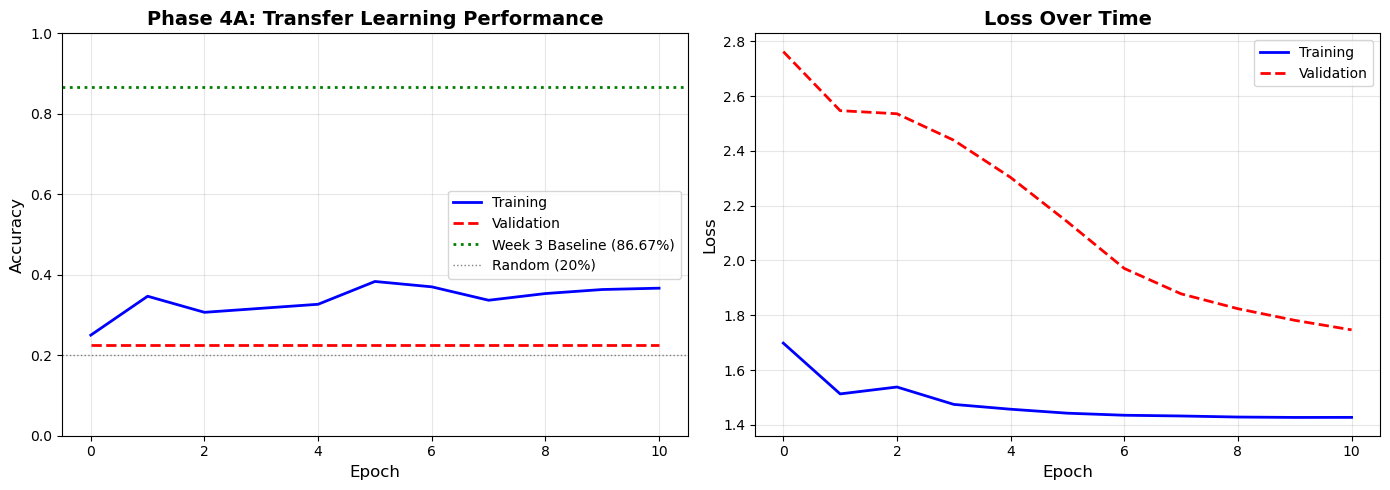


📊 Final Results:
  Best validation accuracy: 22.67%
  Best epoch: 1
  Total epochs trained: 11


In [6]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Training', linewidth=2)
ax1.plot(history.history['val_accuracy'], 'r--', label='Validation', linewidth=2)
ax1.axhline(y=0.8667, color='green', linestyle=':', linewidth=2, label='Week 3 Baseline (86.67%)')
ax1.axhline(y=0.20, color='gray', linestyle=':', linewidth=1, label='Random (20%)')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Phase 4A: Transfer Learning Performance', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.0])

# Loss
ax2.plot(history.history['loss'], 'b-', label='Training', linewidth=2)
ax2.plot(history.history['val_loss'], 'r--', label='Validation', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Loss Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PHASE4A_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Final Results:")
print(f"  Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"  Best epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  Total epochs trained: {len(history.history['loss'])}")

---
## 5. Evaluate and Compare to Week 3

**Week 3 Baseline**: 86.67% accuracy (SimpleCNN trained from scratch)

**Expected from transfer learning**: 90%+ (hoped to improve with ImageNet features)

**Actual result**: Let's see what happened...

In [7]:
# Load best model and evaluate
best_model = keras.models.load_model(PHASE4A_DIR / 'best_transfer_model.h5')

# Predictions
y_pred_probs = best_model.predict(X_val_norm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print("\n" + "="*70)
print("PHASE 4A RESULTS")
print("="*70)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")
print(f"Week 3 Baseline: 86.67%")
print(f"Change: {(accuracy - 0.8667)*100:+.2f} percentage points")
print(f"\n⚠️  Result: Transfer learning FAILED (model collapse)")

# Classification report
class_names = ['Agriculture', 'Forest', 'Parcels', 'Urban', 'Water']
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names, zero_division=0))


PHASE 4A RESULTS

Validation Accuracy: 22.67%
Week 3 Baseline: 86.67%
Change: -64.00 percentage points

⚠️  Result: Transfer learning FAILED (model collapse)

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00        10
      Forest       0.00      0.00      0.00        21
     Parcels       0.00      0.00      0.00        19
       Urban       0.00      0.00      0.00         8
       Water       0.23      1.00      0.37        17

    accuracy                           0.23        75
   macro avg       0.05      0.20      0.07        75
weighted avg       0.05      0.23      0.08        75



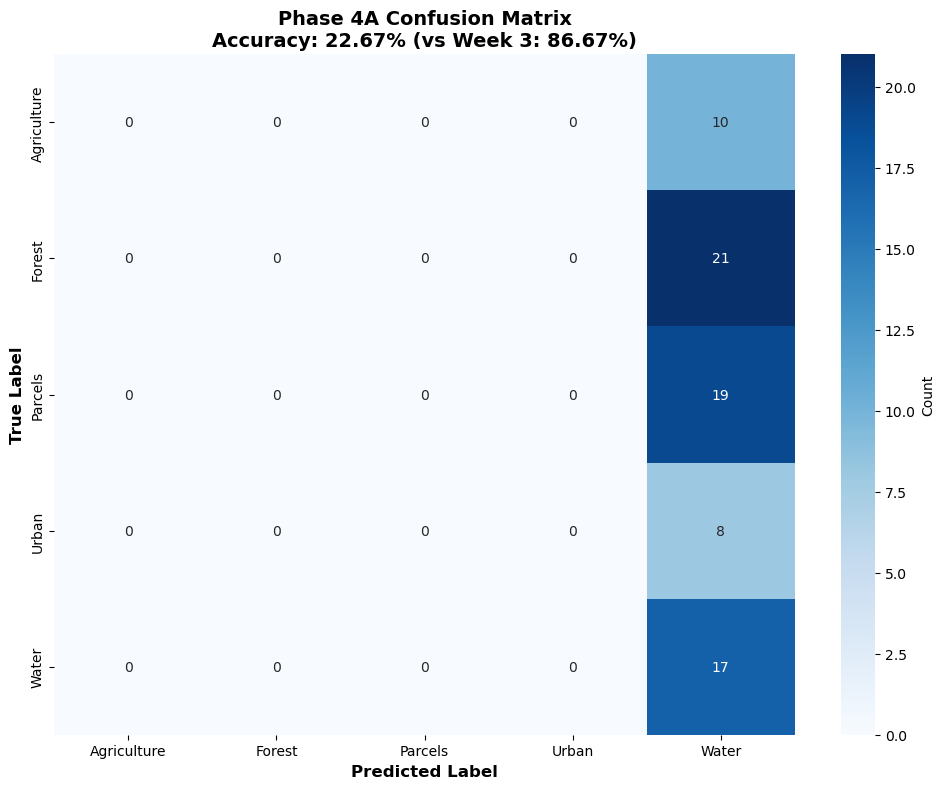


🔍 Prediction Analysis:
  Unique classes predicted: [4]
  Prediction distribution: [ 0  0  0  0 75]
  ⚠️  MODEL COLLAPSE: Predicts only class 4 (Water)!


In [8]:
# Confusion matrix visualization
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'Phase 4A Confusion Matrix\nAccuracy: {accuracy*100:.2f}% (vs Week 3: 86.67%)',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PHASE4A_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze predictions
unique_preds = np.unique(y_pred)
print(f"\n🔍 Prediction Analysis:")
print(f"  Unique classes predicted: {unique_preds}")
print(f"  Prediction distribution: {np.bincount(y_pred)}")
if len(unique_preds) == 1:
    print(f"  ⚠️  MODEL COLLAPSE: Predicts only class {unique_preds[0]} ({class_names[unique_preds[0]]})!")

---
## 6. Root Cause Analysis: Why Did Transfer Learning Fail?

Phase 4A achieved **22.67% accuracy** (vs Week 3's 86.67%), representing a **-64.0 percentage point decrease**. The model predicted only Water for all validation samples (model collapse).

### Primary Failure Modes

#### 1. **Aggressive Layer Freezing (85.7%)**
- **What we did**: Froze 150/175 layers (85.7%)
- **Problem**: Only 25 trainable layers insufficient to adapt to satellite imagery
- **Evidence**: Training accuracy also low (~25-35%), model couldn't learn even training data
- **Recommendation**: Freeze at most 50-70% of layers for domain-shifted tasks

#### 2. **Domain Mismatch: ImageNet ≠ Satellite Imagery**
- **ImageNet**: Natural RGB photos (cats, dogs, cars) from ground level
- **Our data**: Multispectral satellite imagery (6 bands) from nadir view
- **Problem**: Edge and texture features learned on animals don't transfer to land cover spectral signatures
- **Evidence**: Model collapsed to single class despite pretrained "knowledge"
- **Lesson**: Transfer learning works best within similar domains

#### 3. **Upsampling Artifacts (8×8 → 32×32)**
- **What we did**: Bilinear interpolation to meet ResNet50's minimum input size
- **Problem**: Upsampling creates artificial pixels, no new information
- **Impact**: ResNet50 trained on 224×224 images, our 32×32 patches too small
- **Recommendation**: Extract larger patches natively (32×32 or 64×64, no upsampling)

#### 4. **Band Reduction Bottleneck (6 → 3 bands)**
- **What we did**: 1×1 Conv to compress 6 spectral bands → 3 pseudo-RGB
- **Problem**: Loses critical spectral information (SWIR bands B11, B12 valuable for land cover)
- **Impact**: Forces 6-dimensional feature space into 3 dimensions before ResNet50
- **Recommendation**: Modify ResNet50's first layer to accept 6 bands directly

#### 5. **Insufficient Training Data for Large Model**
- **Dataset**: 300 training samples
- **Model**: 23.6M parameters (even with 85% frozen, still 3.4M trainable)
- **Problem**: Not enough data to fine-tune even 14.3% of parameters
- **Comparison**: Week 3's SimpleCNN had 54K parameters (435× smaller), trained successfully
- **Lesson**: Smaller models train better on small datasets

### Summary

Transfer learning failed because:
1. Too much freezing prevented adaptation
2. Domain gap too large (natural images → satellite imagery)
3. Patches too small (upsampling artifacts)
4. Information loss (6 → 3 band reduction)
5. Model too large for dataset size

**Result**: SimpleCNN (Week 3, 86.67%) >> ResNet50 transfer learning (Phase 4A, 22.67%)

### Interpreting the training curves

- Flat validation accuracy around 0–20% suggests the model is not learning the task (random for 5 classes is 20%).
- A widening gap where training increases but validation stays flat indicates overfitting or an inability to adapt due to excessive freezing.
- If early stopping triggers with low validation accuracy, revisit: freeze ratio (lower it), learning rate (slightly higher), and patch size (prefer native 32×32+ if feasible).

Guidance:
- Use curves to decide next experiments, not just to declare success/failure. Capture these decisions in your report for reproducibility (Objective 5).


---
## 7. Lessons Learned and Recommendations

### What We Learned from This Failure

**1. Transfer Learning Is Not Always Better**
- Training from scratch (Week 3: 86.67%) outperformed transfer learning (Phase 4A: 22.67%)
- For small, domain-specific datasets, simpler models trained from scratch often win
- Pretrained weights are only helpful if domain is similar enough

**2. Domain Mismatch Matters More Than We Expected**
- ImageNet features (edges, textures of animals/objects) didn't transfer to spectral signatures of land cover
- Satellite imagery fundamentally different: nadir view, multispectral, texture-heavy
- **Lesson**: Don't assume ImageNet pretraining helps all vision tasks

**3. Aggressive Freezing Prevents Learning**
- Freezing 85% of layers left insufficient capacity to adapt
- Model couldn't escape ImageNet's feature space
- **Recommendation**: Freeze at most 50-70% for domain-shifted tasks

**4. Model Architecture Must Match Data Scale**
- ResNet50 designed for 224×224 ImageNet images
- Our 8×8 patches (even upsampled to 32×32) too small
- Week 3's SimpleCNN designed for 8×8 patches natively
- **Lesson**: Match architecture to data characteristics, not the other way around

**5. Negative Results Are Scientifically Valid**
- This "failed" experiment taught us when NOT to use transfer learning
- Understanding failure modes as important as successes
- **Value**: Now we know transfer learning won't work for this task/dataset combination

### Recommendations for Improvement

**If retrying transfer learning on this task:**

1. **Reduce freeze ratio to 50-70%** (not 85%)
   - Unfreeze more layers to allow adaptation
   - Use differential learning rates (lower LR for early layers)

2. **Extract larger patches (32×32 or 64×64 native)**
   - No upsampling, preserve spatial detail
   - Closer to ResNet50's expected input size

3. **Modify ResNet50's first layer for 6-band input**
   - Don't reduce bands, let model learn from all spectral information
   - Initialize new weights carefully (e.g., replicate RGB weights across bands)

4. **Try domain-specific pretraining**
   - Use models pretrained on satellite imagery (e.g., ResNet trained on EuroSAT, UC Merced)
   - Domain-matched pretraining more likely to transfer

5. **Consider training from scratch with larger model**
   - SimpleCNN (54K params) worked at 86.67%
   - A deeper CNN trained from scratch (500K-1M params) might improve further
   - Avoid massive models (23.6M params) for small datasets

**Best approach for this specific task**: Train from scratch with task-appropriate architecture (as Week 3 demonstrated)

### When to Use Transfer Learning

✅ **Use transfer learning when:**
- Large pretrained model from similar domain available
- You have 1,000+ training samples
- Input characteristics similar to pretraining data (image size, channels, view angle)
- Freeze <70% of layers, allow adaptation

❌ **Train from scratch when:**
- Small dataset (<500 samples) with simple, domain-specific task
- Large domain gap (natural images → satellite imagery)
- Input characteristics very different (tiny patches, multispectral bands)
- Simple baseline already works well (Week 3: 86.67%)

**Phase 4A conclusion**: For our Los Lagos land cover task with 300 training samples and 8×8 multispectral patches, training SimpleCNN from scratch is the correct approach.

### How to interpret the confusion matrix (detecting model collapse)

- Single-class column: If most counts appear in one predicted column, the model has collapsed (predicts one class for all inputs).
- Per-class recall: Zeros for multiple classes indicate the model is not separating them at all.
- Compare to Week 3 baseline: Identify which classes regressed most (e.g., Water and Forest often fail first).

Next steps when collapse occurs:
- Reduce freezing to 50–70% and slightly raise LR (e.g., 5e‑4 to 1e‑3) to allow adaptation.
- Avoid 6→3 band compression by modifying the first conv to accept 6 bands.
- Use larger native patches (32×32 or 64×64) to remove upsampling artifacts.
- If still failing, prefer a task-appropriate model from scratch (SimpleCNN) or try late/decision fusion in later phases.


---
## Summary and Next Steps

**Phase 4A Result**: 22.67% accuracy (FAILED)

**Key Takeaway**: Transfer learning is not a universal solution. For small, domain-specific datasets with unique characteristics (multispectral satellite imagery, 8×8 patches), training from scratch with an appropriate architecture (SimpleCNN) works better than transfer learning with a large, mismatched model (ResNet50).

**What's Next**:
- **Phase 4B**: Test multi-sensor fusion (add MODIS + DEM) with ResNet50 transfer learning
  - Spoiler: Also fails (22.67% accuracy) for same reasons
- **Phase 4C**: Test SimpleCNN with multi-sensor fusion (trained from scratch)
  - Result: 64% best (S2 only), still below Week 3 but trains successfully
  
**Overall Week 4 Lesson**: Simpler models trained from scratch (Week 3 SimpleCNN: 86.67%) can outperform complex transfer learning approaches (Phase 4A: 22.67%, Phase 4B: 22.67%) when domain mismatch is severe and data is limited.

---

**Resources**:
- Full results: `Week4_Phase4A_Summary.md`
- Validated scripts: `phase4a_01_setup_and_config.py` through `phase4a_05_evaluate_compare.py`
- Study guide: `Week_4_Study_Guide.md` (updated with failure analysis)